In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime

from arch import arch_model
from scipy.stats import norm

from tqdm import tqdm

In [14]:
def get_data(symbol, risk_free, volatility_proxy, time_period):
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=time_period * 252)

    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['log_returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    stock_data.dropna(subset=['log_returns'], inplace=True)

    risk_free_data = yf.download(risk_free, start=start_date, end=end_date)[['Close']] / 100
    risk_free_data.columns = ["Rate"]

    volatility_proxy_data = yf.download(volatility_proxy, start=start_date, end=end_date)[['Close']]
    volatility_proxy_data.columns = ['Vol_Proxy']

    volatility_proxy_data.loc[:, 'implied_volatility'] = volatility_proxy_data['Vol_Proxy'] / 100.0

    data = pd.merge(stock_data, risk_free_data, how='left', on='Date')
    data = pd.merge(data, volatility_proxy_data[['implied_volatility']], how='left', on='Date')

    data.ffill(inplace=True)


    ##### ESTIMATE VOLATILITY OF STOCK WITH GARCH MOODEL #####
    garch_model = arch_model(data['log_returns'] * 100, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    garch_fit = garch_model.fit(disp="off")
    data['volatility'] = garch_fit.conditional_volatility
    data['annualized_volatility'] = data['volatility'] * np.sqrt(252) / 100
    data['smoothed_annualized_volatility'] = data['annualized_volatility'].rolling(window=3, min_periods=1).mean()
    data.dropna(subset='smoothed_annualized_volatility', inplace=True)


    plt.figure(figsize=(10, 12))
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'], label=f"{symbol}", color='blue')
    plt.title(f"{symbol} Price")

    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['implied_volatility'], label=f"Implied Vol ({volatility_proxy}-based)", color='red')
    plt.plot(data.index, data['annualized_volatility'], label="GARCH Estimated Annual Vol", ls="--", alpha=0.5)
    plt.title(f"Volatilities ({volatility_proxy} and GARCH)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['Rate'], label="Risk Free Rate", color='black')
    plt.title("Risk Free Rate")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return data

In [105]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from arch import arch_model
from tick.hawkes import SimuHawkes, HawkesKernelExp

def generate_gbm_prices(start_price, mu, sigma, days):
    """
    Generate synthetic stock prices using Geometric Brownian Motion.

    Parameters:
    - start_price: Initial stock price
    - mu: Expected return
    - sigma: Volatility
    - days: Number of trading days to simulate

    Returns:
    - pd.Series of simulated stock prices
    """
    dt = 1/252  # Assuming 252 trading days in a year
    random_returns = np.random.normal(loc=(mu - 0.5 * sigma**2) * dt,
                                     scale=sigma * np.sqrt(dt),
                                     size=days)
    price_series = start_price * np.exp(np.cumsum(random_returns))
    return pd.Series(price_series)

def generate_risk_free_rates(rate, days):
    """
    Generate synthetic risk-free rates.

    Parameters:
    - rate: Annual risk-free rate (e.g., 0.01 for 1%)
    - days: Number of trading days

    Returns:
    - pd.Series of risk-free rates
    """
    daily_rate = rate / 252
    return pd.Series([daily_rate] * days)

def generate_hawkes_volatility(days, dt=1/252, mu=0.8, alpha=0.6, beta=0.7, jump_size=0.04, seed=123):
    """
    Generate synthetic volatility data using a Hawkes process.

    Parameters:
    - days: Number of trading days to simulate
    - dt: Time step in years (default: 1/252 for daily)
    - mu: Baseline intensity (events per day)
    - alpha: Excitation parameter (alpha)
    - beta: Decay parameter (beta)
    - jump_size: Volatility jump size per event
    - seed: Random seed for reproducibility

    Returns:
    - pd.Series of synthetic volatility values
    """
    # Define the exponential kernel
    kernel = HawkesKernelExp(decay=beta, intensity=alpha)
    kernels = np.array([[kernel]])  # Single-node Hawkes process

    # Define the baseline intensity
    baseline = [mu]

    # Initialize the SimuHawkes object
    hawkes = SimuHawkes(
        kernels=kernels,
        baseline=baseline,
        end_time=days,
        seed=seed,
        verbose=False  # Set to True if you want simulation details
    )

    # Simulate the Hawkes process
    hawkes.simulate()

    # Extract event times for the single node
    event_times = hawkes.timestamps[0]  # List of event times

    # Create a date range aligned with trading days
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=int(days * 1.5))  # Adjust for weekends
    dates = pd.bdate_range(start=start_date, periods=days, freq='C')  # Business days

    # Initialize volatility series
    volatility = np.zeros(len(dates))
    decay_factor = np.exp(-beta * dt)

    # Assign events to dates
    event_days = np.floor(event_times).astype(int)
    for day in event_days:
        if day < len(volatility):
            # Apply the decay to all subsequent days
            decay = decay_factor ** np.arange(len(volatility) - day)
            volatility[day:] += jump_size * decay[:len(volatility) - day]

    # Add a baseline volatility (e.g., 20%)
    volatility += 0.2  # Baseline volatility (20%)

    # Create a pandas Series
    volatility_series = pd.Series(volatility, index=dates)

    return volatility_series

def get_synthetic_data_hawkes(symbol='HawkesStock',
                               risk_free='HawkesRiskFree',
                               volatility_proxy='HawkesVolProxy',
                               time_period=1,  # in years
                               start_price=100,
                               mu=0.08,  # 8% expected annual return
                               sigma=0.25,  # Annual volatility for GBM
                               rf_rate=0.02,  # Annual risk-free rate
                               hawkes_mu=0.8,    # Baseline intensity (events per day)
                               hawkes_alpha=0.6, # Excitation parameter
                               hawkes_beta=0.7,  # Decay parameter
                               hawkes_jump=0.04, # Volatility jump size per event
                               seed=42           # Seed for reproducibility
                              ):
    """
    Generate synthetic data for testing strategies using Hawkes-based volatility.

    Parameters:
    - symbol: Name of the synthetic stock
    - risk_free: Name of the synthetic risk-free rate
    - volatility_proxy: Name of the synthetic volatility proxy
    - time_period: Number of years to simulate
    - start_price: Initial stock price
    - mu: Expected annual return of the stock
    - sigma: Annual volatility of the stock (for GBM)
    - rf_rate: Annual risk-free rate
    - hawkes_mu: Baseline intensity for Hawkes process (events per day)
    - hawkes_alpha: Excitation parameter for Hawkes process
    - hawkes_beta: Decay parameter for Hawkes process
    - hawkes_jump: Volatility jump size per event
    - seed: Random seed for reproducibility

    Returns:
    - pd.DataFrame with synthetic data
    """
    # Calculate total trading days
    total_days = int(time_period * 252)

    # Generate date range
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=int(total_days * 1.5))  # Adjust for weekends
    dates = pd.bdate_range(start=start_date, periods=total_days, freq='C')  # Business days

    # Generate synthetic stock prices using GBM
    stock_prices = generate_gbm_prices(start_price, mu, sigma, total_days)
    stock_prices.index = dates

    # Calculate log returns
    log_returns = np.log(stock_prices / stock_prices.shift(1))
    stock_data = pd.DataFrame({
        'Close': stock_prices,
        'log_returns': log_returns
    })
    stock_data.dropna(subset=['log_returns'], inplace=True)

    # Generate synthetic risk-free rate data
    risk_free_data = generate_risk_free_rates(rf_rate, len(stock_data)) * 100  # Convert to percentage
    risk_free_df = pd.DataFrame({'Rate': risk_free_data.values}, index=stock_data.index)

    # Generate synthetic volatility proxy data using Hawkes process
    volatility_proxy_data = generate_hawkes_volatility(
        days=len(stock_data),
        mu=hawkes_mu,
        alpha=hawkes_alpha,
        beta=hawkes_beta,
        jump_size=hawkes_jump,
        seed=seed
    )
    volatility_proxy_data.name = 'Vol_Proxy'

    # Since volatility is a continuous measure, we can use it directly
    # Alternatively, you could normalize or scale it as needed
    stock_data['implied_volatility'] = volatility_proxy_data.values

    # Merge all data
    data = stock_data.copy()
    data = pd.merge(data, risk_free_df, how='left', left_index=True, right_index=True)

    # Forward fill any missing data
    data.ffill(inplace=True)

    ##### ESTIMATE VOLATILITY OF STOCK WITH GARCH MODEL #####
    garch_model = arch_model(data['log_returns'] * 100, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    garch_fit = garch_model.fit(disp="off")
    data['volatility'] = garch_fit.conditional_volatility
    data['annualized_volatility'] = data['volatility'] * np.sqrt(252) / 100
    data['smoothed_annualized_volatility'] = data['annualized_volatility'].rolling(window=3, min_periods=1).mean()
    data.dropna(subset=['smoothed_annualized_volatility'], inplace=True)

    ##### Plotting #####
    plt.figure(figsize=(14, 16))

    # Plot Stock Price
    plt.subplot(4, 1, 1)
    plt.plot(data.index, data['Close'], label=f"{symbol}", color='blue')
    plt.title(f"{symbol} Price")
    plt.legend()

    # Plot Volatility Proxy (Hawkes-Based) and GARCH Estimated Volatility
    plt.subplot(4, 1, 2)
    plt.plot(data.index, data['implied_volatility'], label=f"Hawkes-Based Volatility Proxy", color='red')
    plt.plot(data.index, data['annualized_volatility'], label="GARCH Estimated Annual Vol", ls="--", alpha=0.7)
    plt.title(f"Volatilities ({volatility_proxy} and GARCH)")
    plt.legend()

    # Plot Risk-Free Rate
    plt.subplot(4, 1, 3)
    plt.plot(data.index, data['Rate'], label="Risk Free Rate", color='black')
    plt.title("Risk Free Rate")
    plt.legend()

    # Plot Log Returns
    plt.subplot(4, 1, 4)
    plt.plot(data.index, data['log_returns'], label="Log Returns", color='green')
    plt.title("Log Returns")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return data

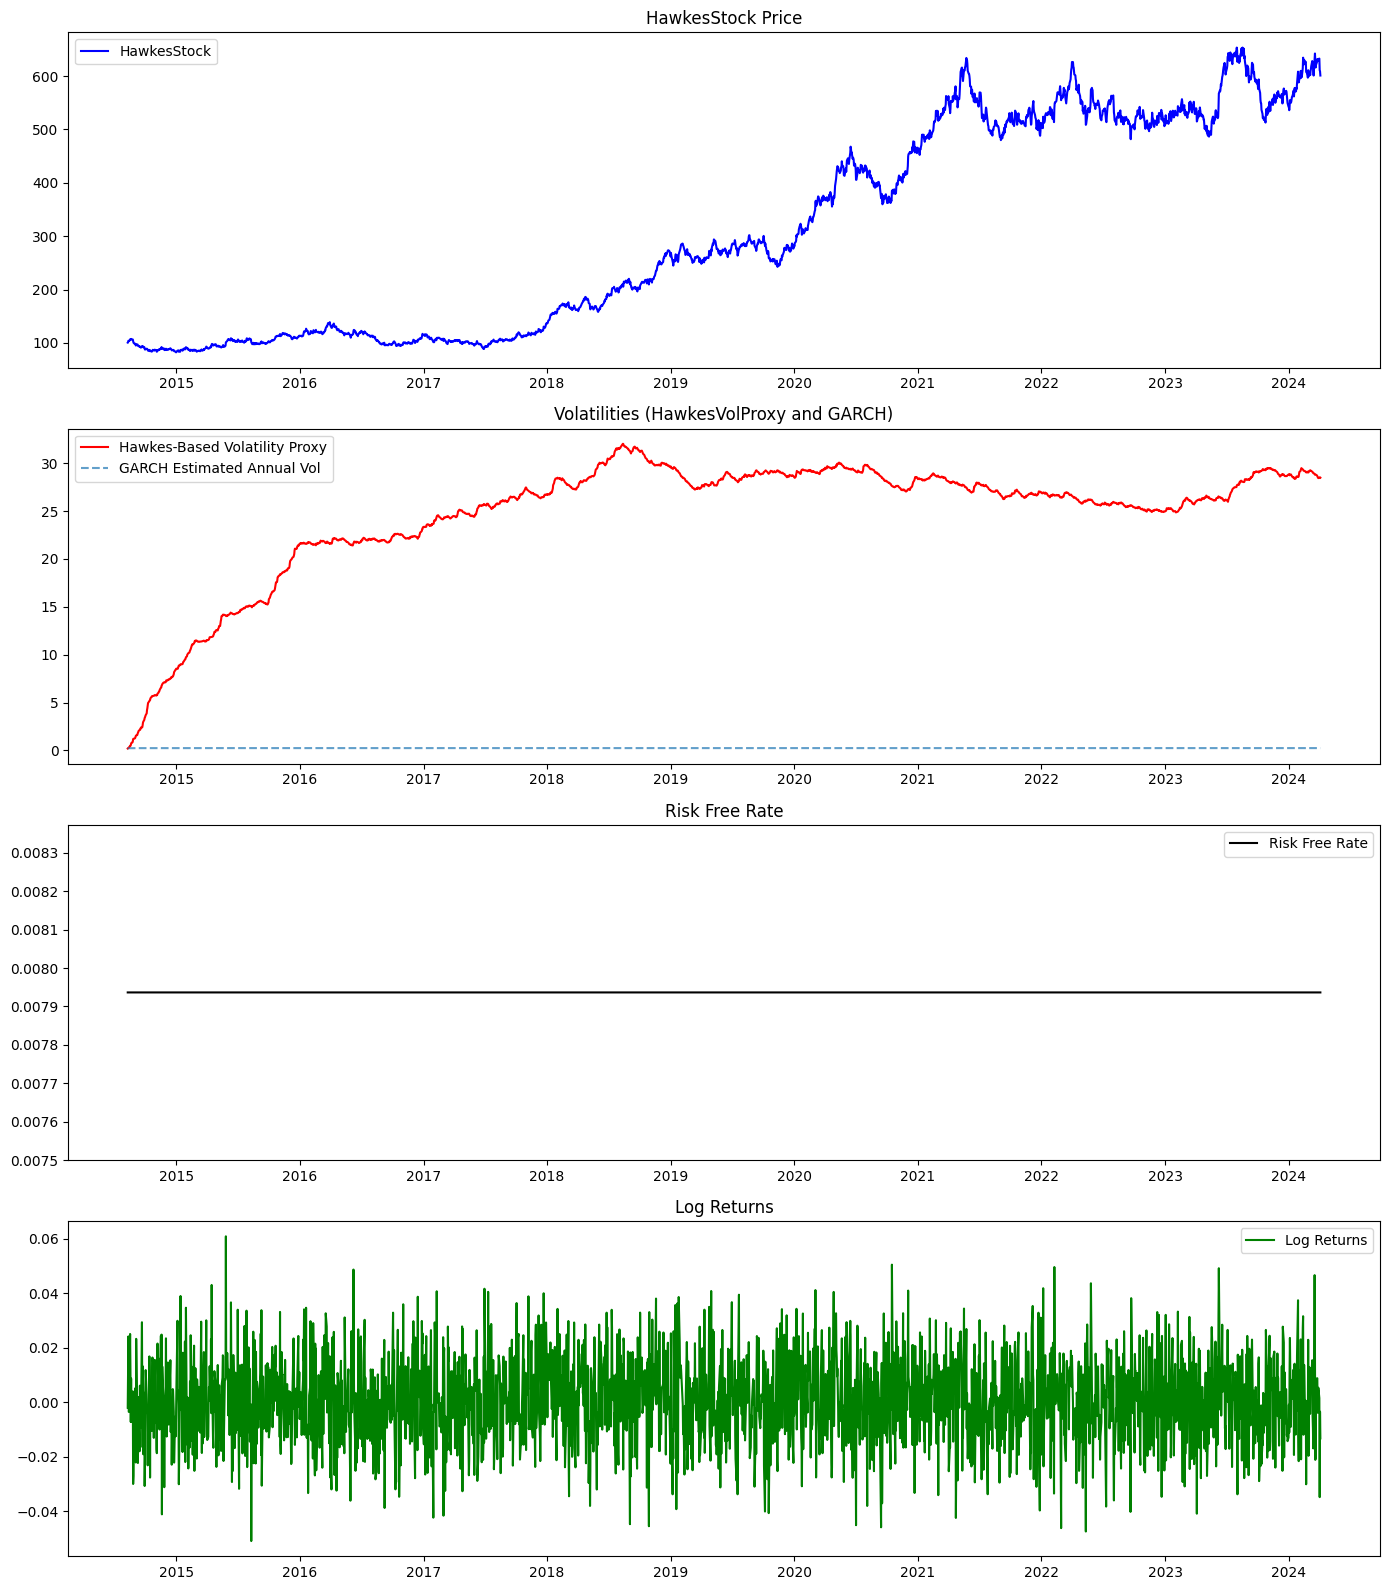

In [106]:
synthetic_data_hawkes = get_synthetic_data_hawkes(
    symbol='HawkesStock',
    risk_free='HawkesRiskFree',
    volatility_proxy='HawkesVolProxy',
    time_period=10,      # 2 years
    start_price=100,
    mu=0.08,            # 8% expected annual return
    sigma=0.25,         # 25% annual volatility for GBM
    rf_rate=0.02,       # 2% annual risk-free rate
    hawkes_mu=0.8,      # 0.8 events per day
    hawkes_alpha=0.6,   # Excitation parameter
    hawkes_beta=0.7,    # Decay parameter
    hawkes_jump=0.04,   # 4% volatility jump per event
    seed=42             # Seed for reproducibility
)

In [113]:
def compute_d1_d2(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def black_scholes(S, K, T, r=0.02, sigma=0.2, option_type='call'):
    d1, d2 = compute_d1_d2(S, K, r=r, sigma=sigma, T=T)
    if option_type == 'call':
        c = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put': 
        c = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Error, option must be of type 'call' or 'put'")
    return c, norm.cdf(d1)

def value_bank(S, N_s, C, N_c):
    bank = -N_c*C + (-N_s)*S
    return bank

def build_initial_positions(data, r=0.02, fees=1/1000, K_multiplier=1.1, use_vix_proxy=False, option_maturity=6/12):
    S0 = data['Close'].iloc[0]
    K0 = int(round(K_multiplier * S0, -1))
    if use_vix_proxy:
        g0 = data['implied_volatility'].iloc[0]
    else:
        g0 = data['annualized_volatility'].iloc[0]
    r0 = data['Rate'].iloc[0]
    T0 = option_maturity

    N_call = 1


    call_price, call_delta = black_scholes(S0, K0, T0, r0, g0, 'call')
    shares = N_call * call_delta

    bank = (-N_call * call_price) + ((shares) * S0)

    initial_fees = (N_call * call_price + abs(shares * S0)) * fees
    bank -= initial_fees
    value_portfolio = bank + (- shares * S0) + (N_call * call_price)

    return {
        "S": S0,
        "K": K0,
        "T":T0,
        "Volatility": g0,
        "Risk Free": r0, 
        "Shares": -shares,
        "Share_Price": S0 * shares,
        "Option_Type": 'call',
        "Option_Price": call_price,
        "Option_Delta": call_delta,
        "Bank": bank,
        "Value_portfolio": value_portfolio,
        "fees_cumsum": initial_fees,
        "fees_transaction": initial_fees
    }

def simulate_trades(data, initial_positions, fees=1/100, day_rebalancing=1, day_rolling=21, K_multiplier=1.1, use_vix_proxy=False, option_maturity=6/12):
    portfolio = {}
    position = initial_positions.copy()
    cumulative_drift = 0  
    portfolio[data.index[0]] = position

    N_call = 1 

    
    # For i = 1 To 252, pas de 1
    for i in tqdm(range(day_rebalancing, len(data), day_rebalancing)):
        prev_position = portfolio[data.index[i - day_rebalancing]].copy()
        S = data['Close'].iloc[i]
        K = prev_position['K']
        if use_vix_proxy:
            g = data['implied_volatility'].iloc[i]
        else:
            g = data['smoothed_annualized_volatility'].iloc[i]

        r = data['Rate'].iloc[i]

        days_elapsed = i
        T = prev_position['T'] - (days_elapsed / 252)
        if T <= 0: # Terminal Condition of the Option
            payoff = np.maximum(S-K,0)
            K = int(round(K_multiplier * S, -1))
            call_price, call_delta = black_scholes(S, K, option_maturity, r, g, 'call') # Buy a new Call Option

            shares_old = prev_position['Shares']
            shares_new = N_call * call_delta
            shares_change = abs(shares_new) - abs(shares_old)

            transaction_fee = call_price * fees

            bank = prev_position['Bank'] * np.exp(r * (day_rebalancing / 252)) # Money Market

            bank -= transaction_fee
            bank += payoff

            transaction_fee = abs(shares_change * S) * fees
            bank -= transaction_fee

            fees_cumsum = prev_position['fees_cumsum'] + transaction_fee

            value_portfolio = bank + (-shares_new * S) + (N_call * call_price)

            total_delta = call_delta - shares_new
            if abs(total_delta) > 1e-6:
                print(f"WARNING: Portfolio not delta-neutral on Day {data.index[i]}. Total Delta: {total_delta:.6f}")

            cumulative_drift += abs(total_delta)

            new_position = {
                "S": S,
                "K": K,
                "T":T,
                "Volatility": g,
                "Risk Free": r,
                "Shares": -shares_new,
                "Share_Price": S * shares_new,
                "Option_Type": 'call',
                "Option_Price": call_price,
                "Option_Delta": call_delta,
                "Bank": bank,
                "Value_portfolio": value_portfolio,
                "fees_transaction": transaction_fee,
                "fees_cumsum": fees_cumsum,
                "Cumulative_Delta_Drift": cumulative_drift
            }

            portfolio[data.index[i]] = new_position
        
        else:
            # Rolling Vol
            # Si vol_ajd > 2*vol_hier on divise taille fenetre
            # window_length = 5
            # rolling_g = data['smoothed_annualized_volatility'].iloc[i-window_length:i].mean()
            # if g > 2*rolling_g:
            #     window_length = window_length // 2
            # condition sur r, si on veut faire bosser l'argent sur un MM plutot que sur le market

            if (i % day_rolling == 0):

                # Old Option to Sell
                K = prev_position['K']
                call_price, call_delta = black_scholes(S, K, T, r, g, 'call')

                shares_old = prev_position['Shares']
                shares_new = N_call * call_delta
                shares_change = abs(shares_new) - abs(shares_old)

                bank = prev_position['Bank'] * np.exp(r * (day_rebalancing / 252)) # Money Market

                bank += - call_price * fees

                # New Option to buy
                T = option_maturity
                S = data['Close'].iloc[i]
                K = int(round(K_multiplier * S, -1))
                
                transaction_fee = call_price * fees

                bank -= transaction_fee

                fees_cumsum = prev_position['fees_cumsum'] + transaction_fee
                
                value_portfolio = bank + (-shares_new * S) + (N_call * call_price)

                total_delta = call_delta - shares_new
                if abs(total_delta) > 1e-6:
                    print(f"WARNING: Portfolio not delta-neutral on Day {data.index[i]}. Total Delta: {total_delta:.6f}")

                cumulative_drift += abs(total_delta)

                new_position = {
                    "S": S,
                    "K": K,
                    "T":T,
                    "Volatility": g,
                    "Risk Free": r,
                    "Shares": -shares_new,
                    "Share_Price": S * shares_new,
                    "Option_Type": 'call',
                    "Option_Price": call_price,
                    "Option_Delta": call_delta,
                    "Bank": bank,
                    "Value_portfolio": value_portfolio,
                    "fees_transaction": transaction_fee,
                    "fees_cumsum": fees_cumsum,
                    "Cumulative_Delta_Drift": cumulative_drift
                }

                portfolio[data.index[i]] = new_position


            else:
                bank = prev_position['Bank'] * np.exp(r * (day_rebalancing / 252)) # Money Market
                call_price, call_delta = black_scholes(S, K, T, r, g, 'call')

                shares_old = prev_position['Shares']
                shares_new = -N_call * call_delta
                shares_change = abs(shares_new) - abs(shares_old)

                transaction_fee = abs(shares_change * S) * fees
                bank -= transaction_fee

                fees_cumsum = prev_position['fees_cumsum'] + transaction_fee

                value_portfolio = bank + (- shares_new * S) + (N_call * call_price)

                total_delta = call_delta - shares_new
                if abs(total_delta) > 1e-6:
                    print(f"WARNING: Portfolio not delta-neutral on Day {data.index[i]}. Total Delta: {total_delta:.6f}")

                cumulative_drift += abs(total_delta)

                new_position = {
                    "S": S,
                    "K": K,
                    "T":T,
                    "Volatility": g,
                    "Risk Free": r,
                    "Shares": -shares_new,
                    "Share_Price": S * shares_new,
                    "Option_Type": 'call',
                    "Option_Price": call_price,
                    "Option_Delta": call_delta,
                    "Bank": bank,
                    "Value_portfolio": value_portfolio,
                    "fees_transaction": transaction_fee,
                    "fees_cumsum": fees_cumsum,
                    "Cumulative_Delta_Drift": cumulative_drift
                }

                portfolio[data.index[i]] = new_position

    results = pd.DataFrame(portfolio).T
    return results

In [70]:
def plot_hedged_portfolio(portfolio_data):
    print("----- Simulation Summary -----")
    if 'Value_portfolio' in portfolio_data.columns:
        print(f"Total Portfolio Value: ${portfolio_data['Value_portfolio'].iloc[-1]:.2f}")
    if 'fees_cumsum' in portfolio_data.columns:
        print(f"Total Cumulative Fees: ${portfolio_data['fees_cumsum'].iloc[-1]:.2f}")
    if 'Cumulative_Delta_Drift' in portfolio_data.columns:
        print(f"Total Cumulative Delta Drift: {portfolio_data['Cumulative_Delta_Drift'].iloc[-1]:.6f}")

    fig1, ax1 = plt.subplots(figsize=(12, 6))

    if 'S' in portfolio_data.columns:
        ax1.plot(portfolio_data['Date'], portfolio_data['S'], label='Stock Price', color='blue')
    if 'K' in portfolio_data.columns:
        ax1.plot(portfolio_data['Date'], portfolio_data['K'], label='Strike Price', color='black', linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Stock Price, Strike Price, and Volatility Over Time', fontsize=16)

    if 'Volatility' in portfolio_data.columns:
        ax2 = ax1.twinx()
        ax2.plot(portfolio_data['Date'], portfolio_data['Volatility'], label='Volatility', color='green')
        ax2.set_ylabel('Volatility', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    else:
        ax1.legend(loc='upper left')

    fig1.tight_layout()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    if 'Value_portfolio' in portfolio_data.columns:
        fig2, ax = plt.subplots(figsize=(12, 6))
        ax.plot(portfolio_data['Date'], portfolio_data['Value_portfolio'], label='Portfolio Value', color='green')
        ax.set_title('Portfolio Value Over Time', fontsize=16)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value ($)', color='green')
        ax.tick_params(axis='y', labelcolor='green')
        ax.legend(loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True)
        fig2.tight_layout()
        plt.show()

    if 'fees_cumsum' in portfolio_data.columns or 'Cumulative_Delta_Drift' in portfolio_data.columns:
        fig3, ax1 = plt.subplots(figsize=(12, 6))

        if 'fees_cumsum' in portfolio_data.columns:
            ax1.plot(portfolio_data['Date'], portfolio_data['fees_cumsum'], label='Cumulative Fees', color='red')
            ax1.set_ylabel('Fees ($)', color='red')
            ax1.tick_params(axis='y', labelcolor='red')
        else:
            ax1.set_ylabel('Fees ($)', color='red')
            ax1.tick_params(axis='y', labelcolor='red')

        ax1.set_xlabel('Date')
        ax1.set_title('Cumulative Fees and Delta Drift Over Time', fontsize=16)

        if 'Cumulative_Delta_Drift' in portfolio_data.columns:
            ax2 = ax1.twinx()
            ax2.plot(portfolio_data['Date'], portfolio_data['Cumulative_Delta_Drift'], label='Cumulative Delta Drift', color='orange')
            ax2.set_ylabel('Delta Drift', color='orange')
            ax2.tick_params(axis='y', labelcolor='orange')

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            ax1.legend(lines_1, labels_1, loc='upper left')

        fig3.tight_layout()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    gamma_hedge = ('Option_Call_Price' in portfolio_data.columns and 
                   'Option_Put_Price' in portfolio_data.columns)

    if gamma_hedge:
        fig4, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(portfolio_data['Date'], portfolio_data['Option_Call_Price'], label='Call Price', color='purple')
        ax1.plot(portfolio_data['Date'], portfolio_data['Option_Put_Price'], label='Put Price', color='magenta')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Option Prices', color='purple')
        ax1.tick_params(axis='y', labelcolor='purple')
        ax1.set_title('Option Prices and Deltas (Gamma Hedge)', fontsize=16)

        ax2 = ax1.twinx()
        if 'Option_Call_Delta' in portfolio_data.columns and 'Option_Put_Delta' in portfolio_data.columns:
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Call_Delta'], label='Call Delta', color='blue')
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Put_Delta'], label='Put Delta', color='cyan')
        ax2.set_ylabel('Delta', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        fig4.tight_layout()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    else:
        if 'Option_Price' in portfolio_data.columns and 'Option_Delta' in portfolio_data.columns:
            fig4, ax1 = plt.subplots(figsize=(12, 6))

            ax1.plot(portfolio_data['Date'], portfolio_data['Option_Price'], label='Option Price', color='purple')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Option Price', color='purple')
            ax1.tick_params(axis='y', labelcolor='purple')
            ax1.set_title('Option Price and Delta (Delta Hedge)', fontsize=16)

            ax2 = ax1.twinx()
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Delta'], label='Option Delta', color='blue')
            ax2.set_ylabel('Delta', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

            fig4.tight_layout()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()


In [117]:
portfolio_data_delta_hedged_garch

,S,K,T,Volatility,Risk Free,Shares,Share_Price,Option_Type,Option_Price,Option_Delta,Bank,Value_portfolio,fees_cumsum,fees_transaction,Cumulative_Delta_Drift,Date
2017-05-15,240.300003,260,1,0.094953,0.01858,-0.278714,66.975077,call,3.74831,0.278714,62.519534,-0.707234,0.707234,0.707234,NaN,2017-05-15
2017-05-22,239.520004,260,1,0.138027,0.01797,-0.343409,82.253241,call,6.979833,0.343409,62.402232,-12.871175,0.777032,0.069798,0.0,2017-05-22
2017-05-30,241.5,270,1,0.107968,0.0176,-0.313844,75.793324,call,4.895652,0.313844,62.326114,-8.571558,0.825989,0.048957,0.0,2017-05-30
2017-06-06,243.210007,270,1,0.097264,0.01712,-0.186739,45.416785,call,2.246971,0.186739,62.30235,19.132535,0.848458,0.02247,0.0,2017-06-06
2017-06-13,244.550003,270,1,0.080923,0.0178,-0.15264,37.328071,call,1.45668,0.15264,62.295223,26.423832,0.863025,0.014567,0.0,2017-06-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08,598.190002,660,-1387.452381,0.183134,0.04192,-0.414312,247.837364,call,29.659029,0.414312,-24.290489,-242.468823,45.435569,0.539103,0.0,2024-11-08
2024-11-15,585.75,640,-1394.952381,0.144111,0.04298,-0.403486,236.341873,call,22.474527,0.403486,-24.599372,-238.466718,45.498984,0.063414,0.0,2024-11-15
2024-11-22,595.51001,660,-1402.472222,0.125688,0.04298,-0.339705,202.297769,call,15.814921,0.339705,-25.158329,-211.641177,45.878805,0.379821,0.0,2024-11-22
2024-12-02,603.630005,660,-1410.011905,0.104796,0.04095,-0.341355,206.05236,call,13.602797,0.341355,-25.324768,-217.774331,45.888767,0.009962,0.0,2024-12-02


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\vince\AppData\Local\Temp\ipykernel_19064\5201043.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volatility_proxy_data.loc[:, 'implied_volatility'] = volatility_proxy_data['Vol_Proxy'] / 100.0


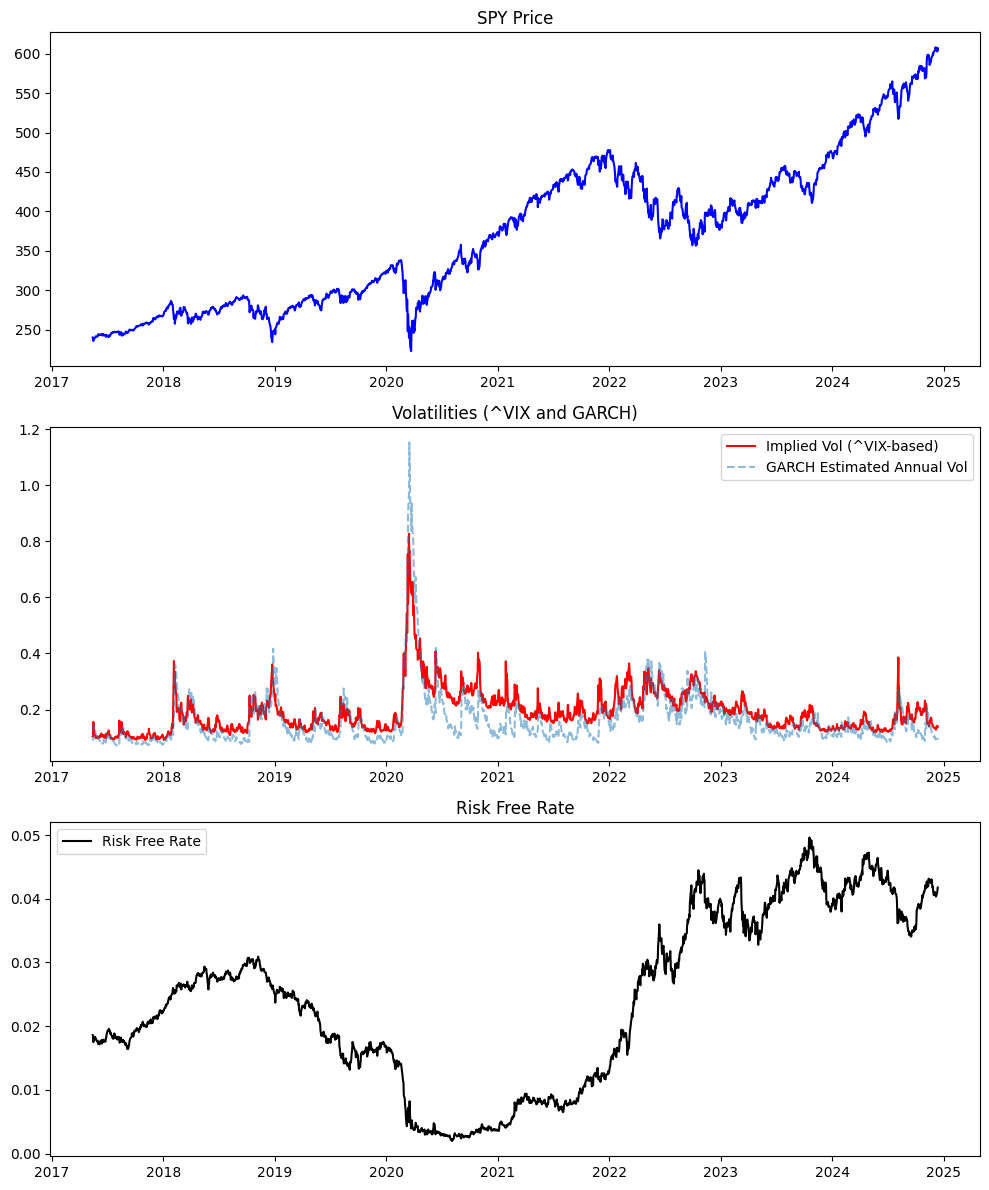

100%|██████████| 381/381 [00:00<00:00, 2064.47it/s]


----- Simulation Summary -----
Total Portfolio Value: $-179.59
Total Cumulative Fees: $46.33
Total Cumulative Delta Drift: 0.000000


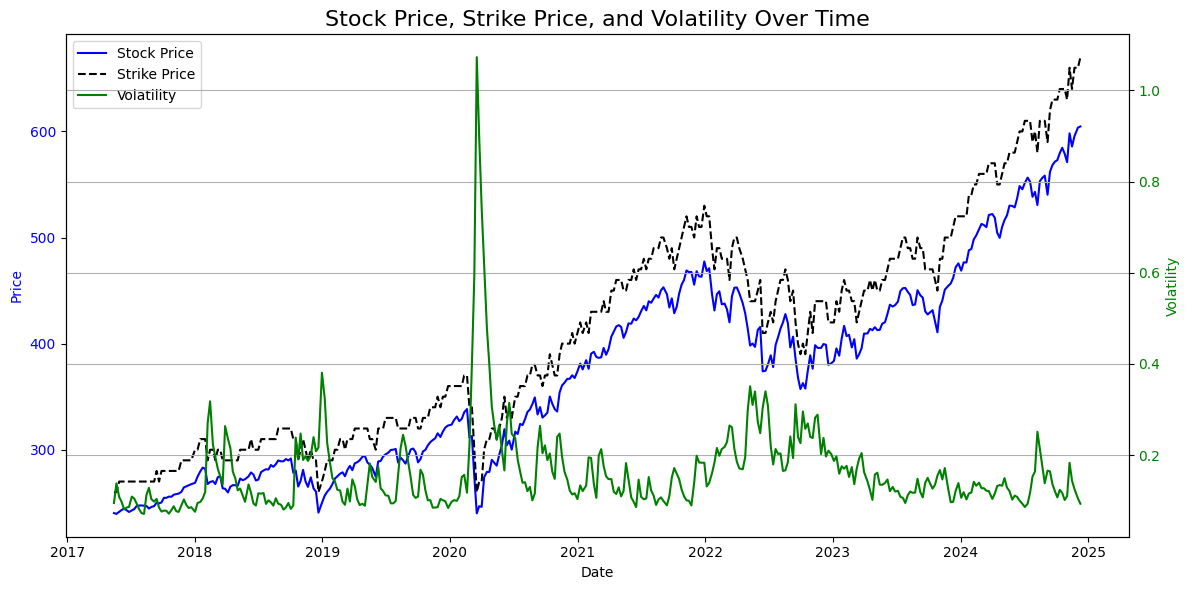

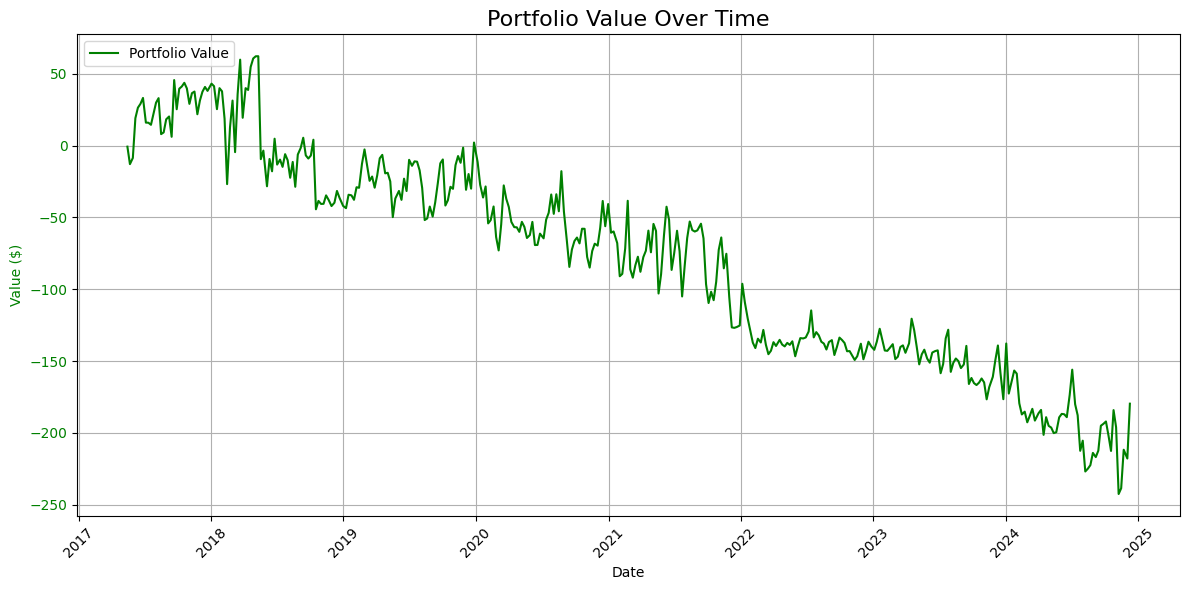

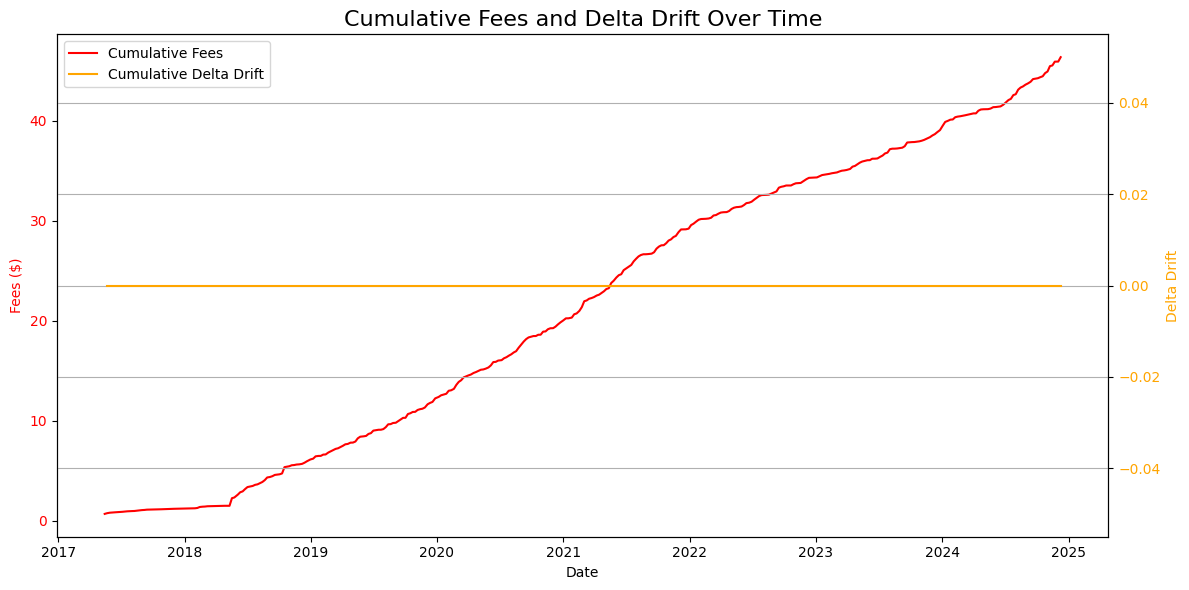

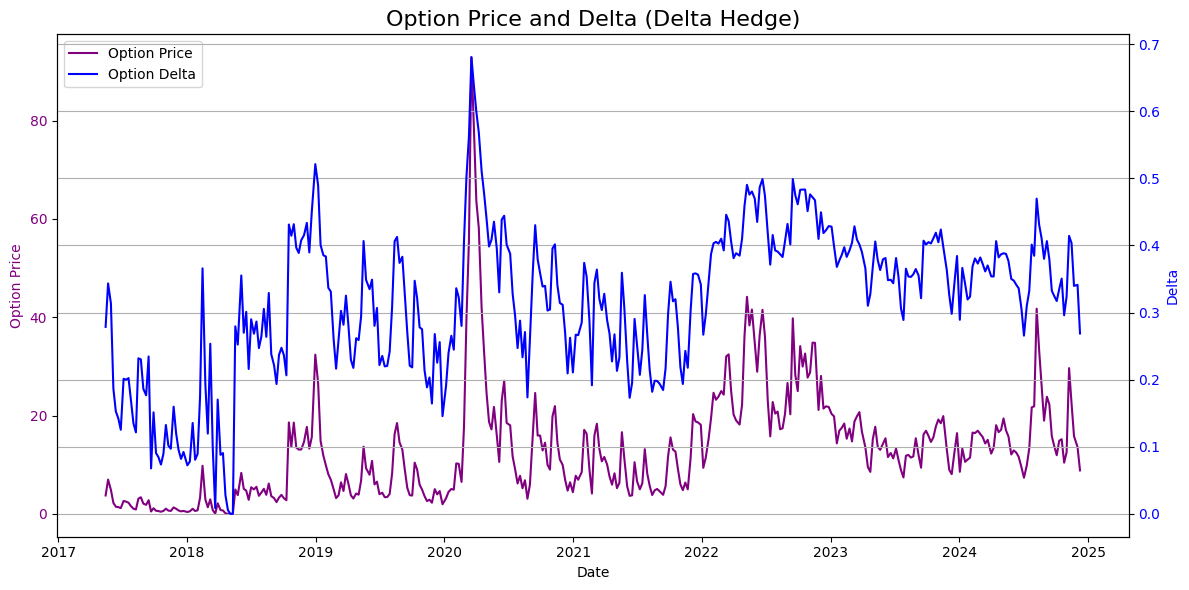

100%|██████████| 503/503 [00:00<00:00, 3337.34it/s]


----- Simulation Summary -----
Total Portfolio Value: $-291.04
Total Cumulative Fees: $23.26
Total Cumulative Delta Drift: 0.000000


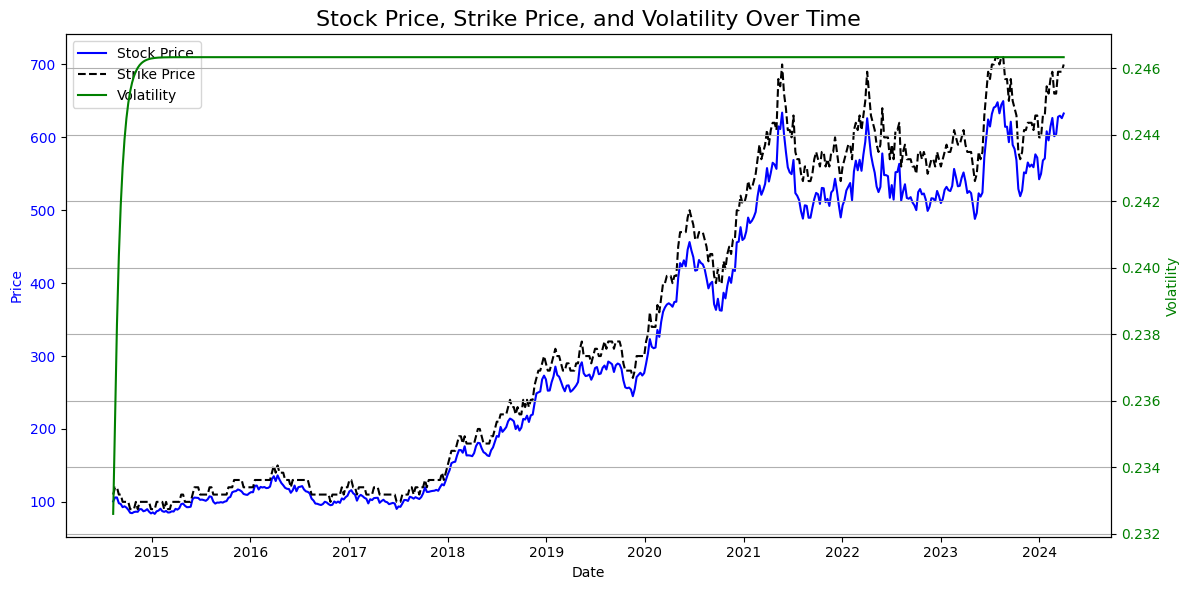

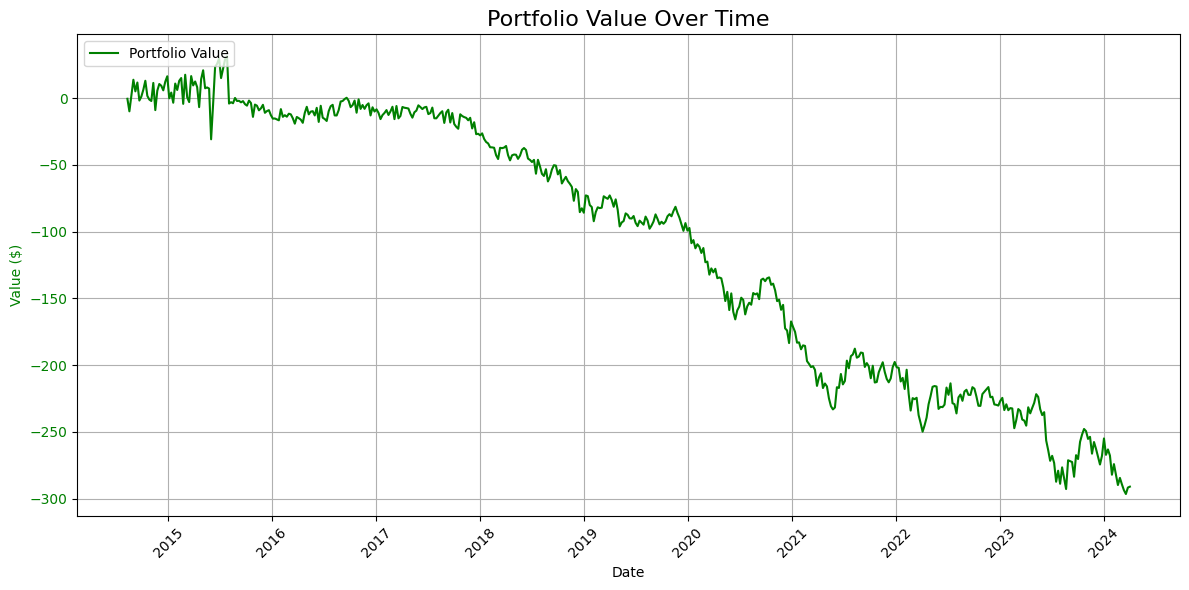

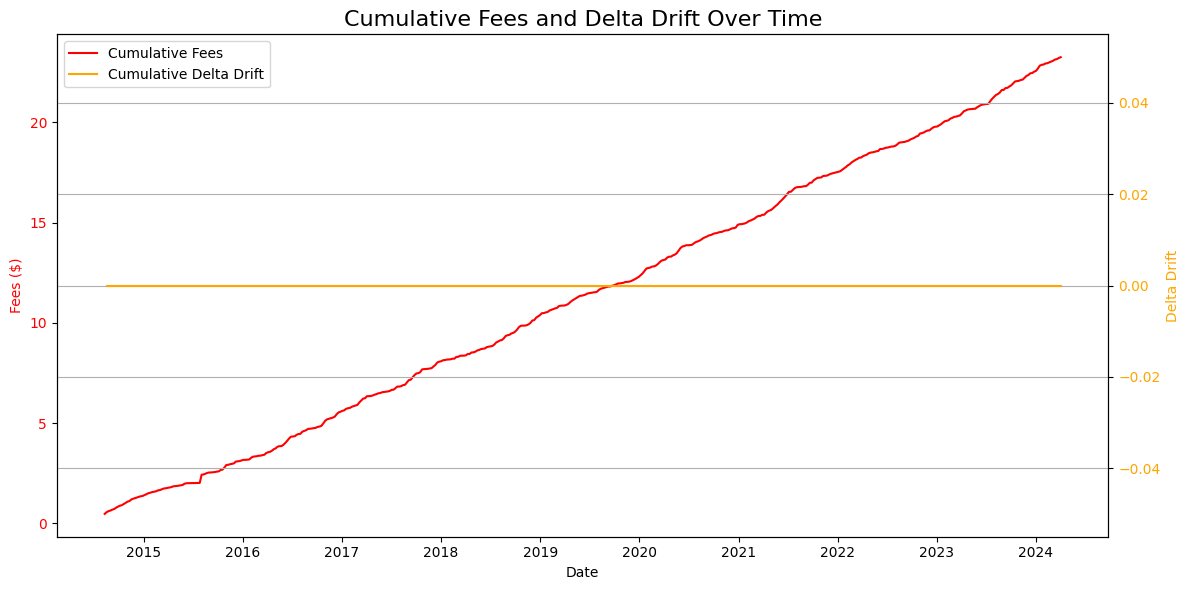

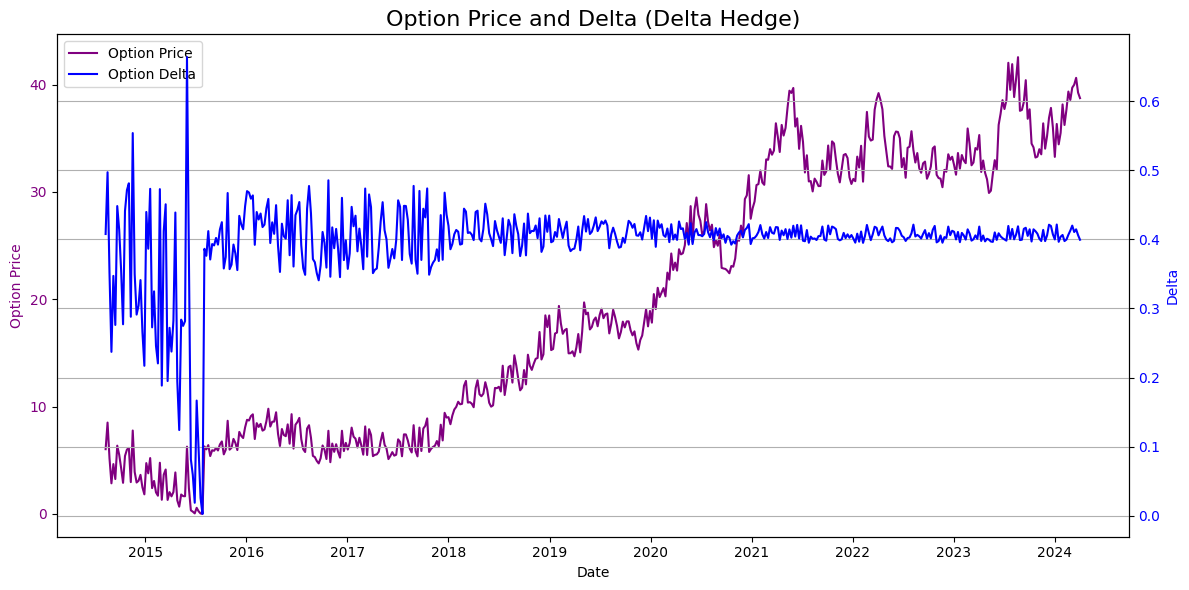

100%|██████████| 381/381 [00:00<00:00, 3416.37it/s]


----- Simulation Summary -----
Total Portfolio Value: $-229.53
Total Cumulative Fees: $36.85
Total Cumulative Delta Drift: 0.000000


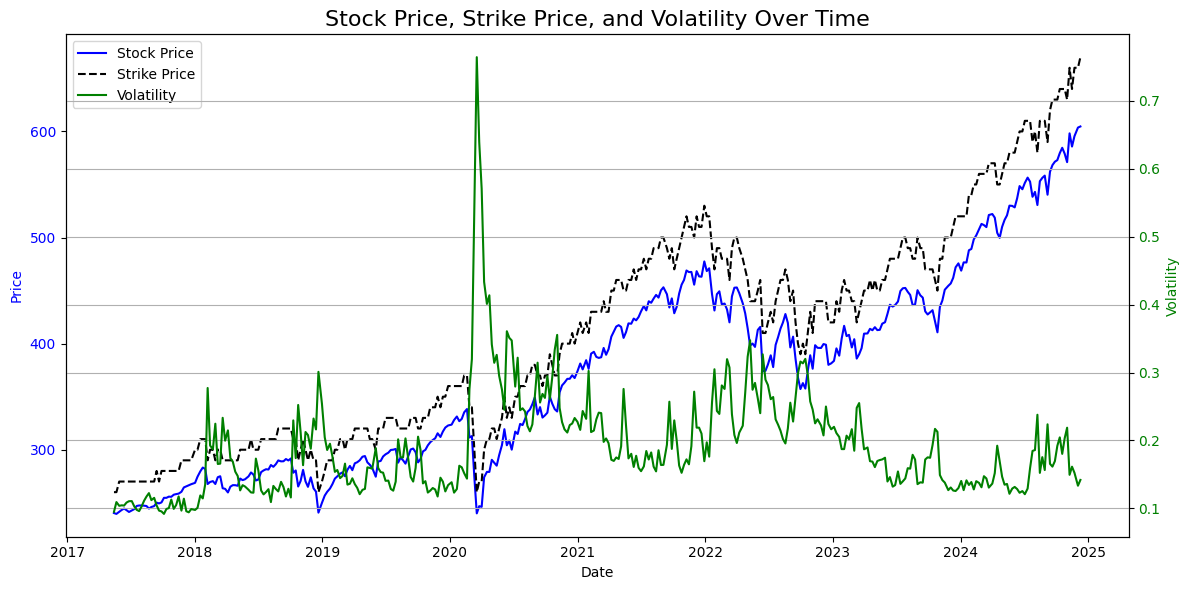

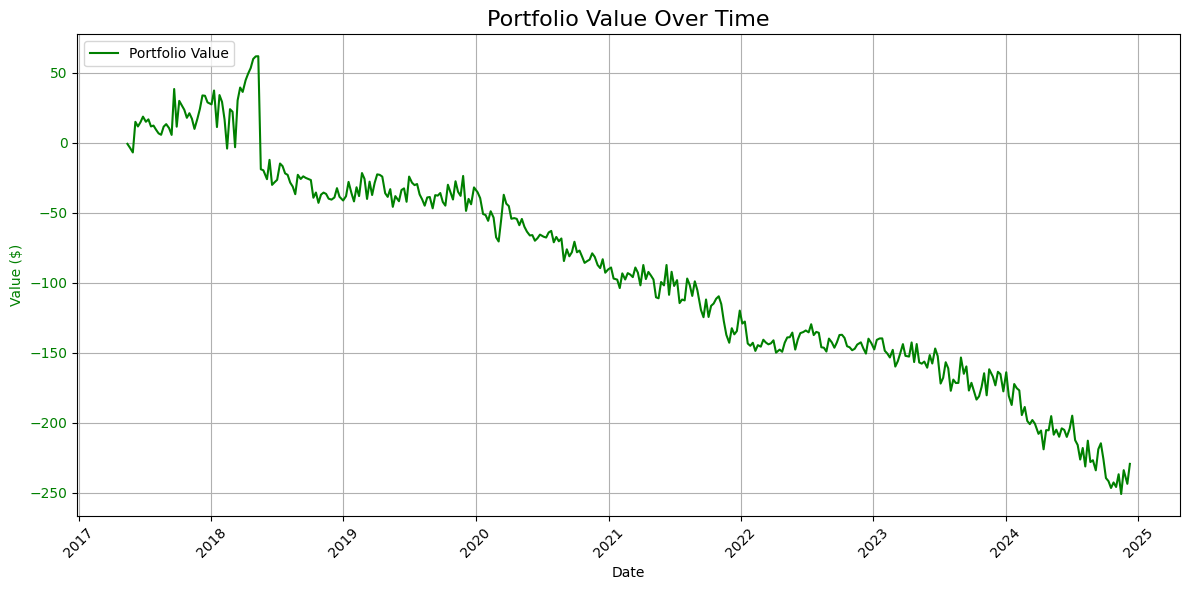

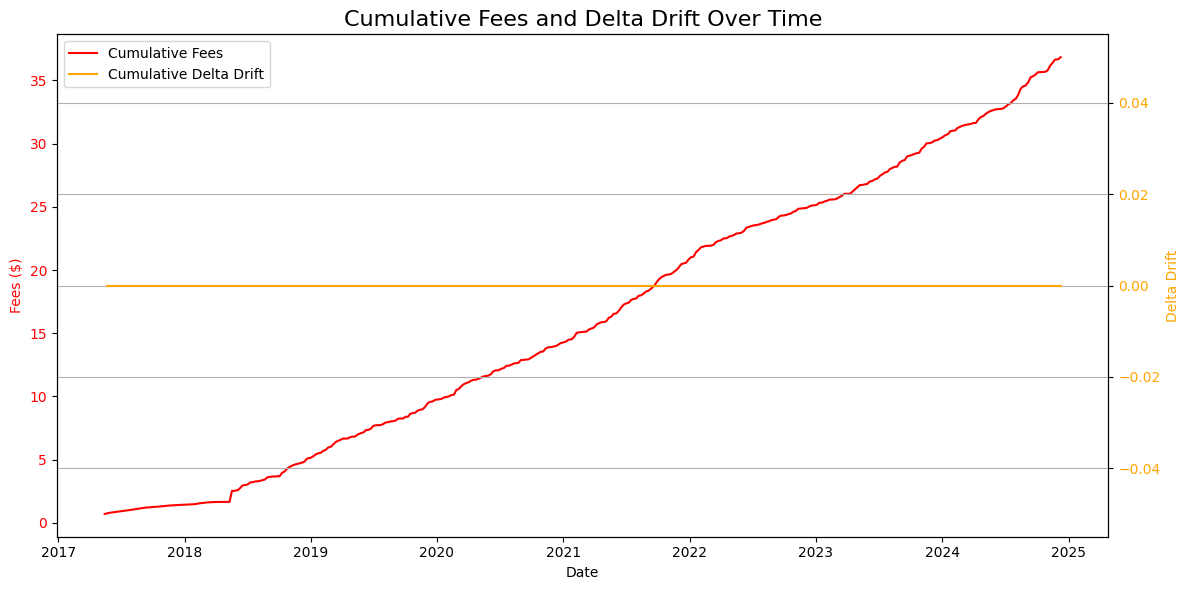

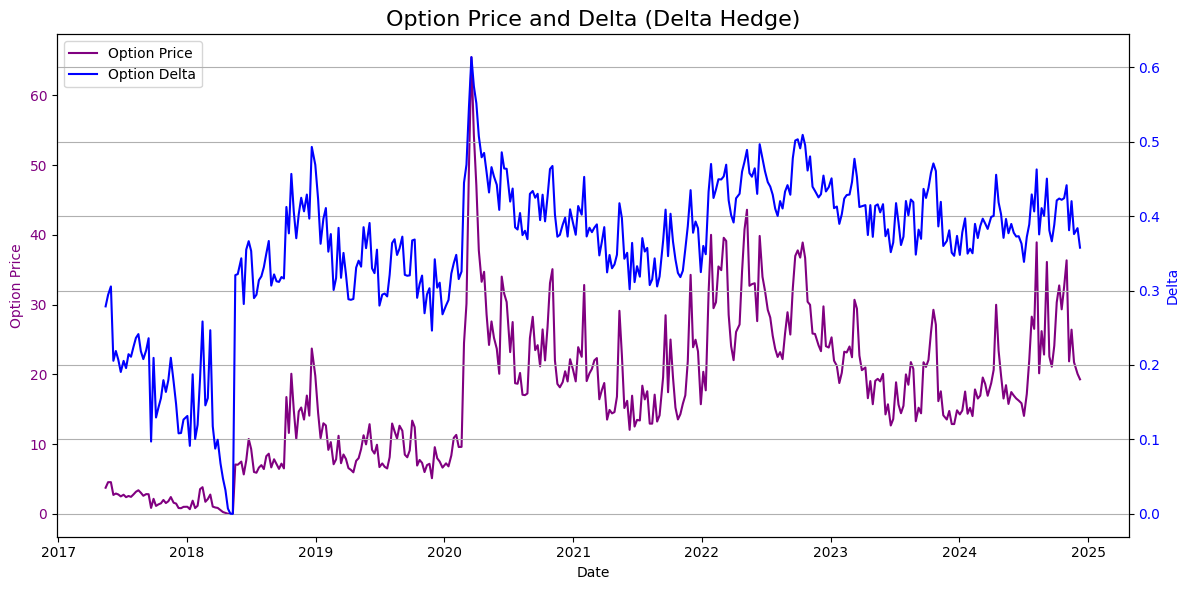

In [118]:
symbol = "SPY"
risk_free = '^FVX'  
vix_symbol = '^VIX'
year_history = 11

data = get_data(symbol=symbol, risk_free=risk_free, volatility_proxy=vix_symbol, time_period=year_history)


day_stock = 5 # Days
day_option = -1 # Days
option_maturity = 1 # 6-Month Maturity
fee_rate = 1 # %



######## GARCH VOLATILITY ###########
initial_positions_delta_hedged_garch = build_initial_positions(data=data, 
                                                                fees=fee_rate/100, 
                                                                option_maturity=option_maturity)
portfolio_data_delta_hedged_garch = simulate_trades(data, 
                                              initial_positions_delta_hedged_garch, 
                                              fees=fee_rate/100, 
                                              day_rebalancing=day_stock, 
                                              day_rolling=day_option, 
                                              use_vix_proxy=False, 
                                              option_maturity=option_maturity)

portfolio_data_delta_hedged_garch['Date'] = pd.to_datetime(portfolio_data_delta_hedged_garch.index)
portfolio_data_delta_hedged_garch.to_csv("portfolio_data_delta_hedged_garch.csv", index=False)
plot_hedged_portfolio(portfolio_data_delta_hedged_garch)






############# SYNTHETIC DATA ############
# synthetic_data = get_synthetic_data(
#     symbol='SyntheticStock',
#     risk_free='SyntheticRiskFree',
#     volatility_proxy='SyntheticVolProxy',
#     time_period=year_history,  # 2 years
#     start_price=data['Close'].iloc[0],
#     mu=0.08,        # 8% expected annual return
#     sigma=0.25,     # 25% annual volatility
#     rf_rate=0.02,   # 2% annual risk-free rate
#     vol_theta=0.1,  # Faster mean reversion for volatility proxy
#     vol_sigma=0.2   # Higher volatility in volatility proxy
# )


initial_positions_delta_hedged_garch_synthetic = build_initial_positions(data=synthetic_data_hawkes , 
                                                                fees=fee_rate/100, 
                                                                option_maturity=option_maturity)
portfolio_data_delta_hedged_garch_synthetic = simulate_trades(synthetic_data_hawkes, 
                                              initial_positions_delta_hedged_garch_synthetic, 
                                              fees=fee_rate/100, 
                                              day_rebalancing=day_stock, 
                                              day_rolling=day_option, 
                                              use_vix_proxy=False, 
                                              option_maturity=option_maturity)


portfolio_data_delta_hedged_garch_synthetic['Date'] = pd.to_datetime(portfolio_data_delta_hedged_garch_synthetic.index)
portfolio_data_delta_hedged_garch_synthetic.to_csv("portfolio_data_delta_hedged_garch_synthetic.csv", index=False)
plot_hedged_portfolio(portfolio_data_delta_hedged_garch_synthetic)
############# SYNTHETIC DATA ############


####### VIX PROXY ##########
initial_positions_delta_hedged_vix = build_initial_positions(data=data, 
                                                                fees=fee_rate/100, 
                                                                use_vix_proxy=False, 
                                                                option_maturity=option_maturity)
portfolio_data_delta_hedged_vix = simulate_trades(data, 
                                              initial_positions_delta_hedged_vix, 
                                              fees=1/100, 
                                              day_rebalancing=day_stock, 
                                              day_rolling=day_option, 
                                              use_vix_proxy=True,
                                              option_maturity=option_maturity)

portfolio_data_delta_hedged_vix['Date'] = pd.to_datetime(portfolio_data_delta_hedged_vix.index)
portfolio_data_delta_hedged_vix.to_csv("portfolio_data_delta_hedged_vix.csv", index=False)
plot_hedged_portfolio(portfolio_data_delta_hedged_vix)

In [57]:
def parameter_sweep(data, day_stock_values, day_option_values, fees=1/100, K_multiplier=1.1, use_vix_proxy=False):
    results = []
    
    for day_stock in tqdm(day_stock_values, desc="Day Stock Iteration"):
        for day_option in day_option_values:
            initial_positions = build_initial_positions(
                data=data,
                fees=fees,
                K_multiplier=K_multiplier,
                use_vix_proxy=use_vix_proxy
            )
            
            portfolio = simulate_trades(
                data=data, 
                initial_positions=initial_positions, 
                fees=fees, 
                day_rebalancing=day_stock, 
                day_rolling=day_option, 
                K_multiplier=K_multiplier, 
                use_vix_proxy=use_vix_proxy
            )
            
            final_value = portfolio['Value_portfolio'].iloc[-1]
            results.append({
                "day_stock": day_stock,
                "day_option": day_option,
                "final_portfolio_value": final_value
            })
    
    results_df = pd.DataFrame(results)
    return results_df


day_stock_values = range(1, 365, 21)      
day_option_values = range(1, 365, 21)  

print("Running parameter sweep for GARCH-based volatility...")
results_garch = parameter_sweep(
    data=data,
    day_stock_values=day_stock_values,
    day_option_values=day_option_values,
    fees=1/100,
    K_multiplier=1.1,
    use_vix_proxy=False
)

print("Running parameter sweep for VIX-based volatility...")
results_vix = parameter_sweep(
    data=data,
    day_stock_values=day_stock_values,
    day_option_values=day_option_values,
    fees=1/100,
    K_multiplier=1.1,
    use_vix_proxy=True
)

results_garch.to_csv("parameter_sweep_results_garch.csv", index=False)
results_vix.to_csv("parameter_sweep_results_vix.csv", index=False)

Running parameter sweep for GARCH-based volatility...


Day Stock Iteration:   0%|          | 0/18 [00:00<?, ?it/s]


UnboundLocalError: local variable 'shares_new' referenced before assignment

C:\Users\vince\AppData\Local\Temp\ipykernel_4804\3659288211.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data_garch = results_garch.pivot("day_stock", "day_option", "final_portfolio_value")
C:\Users\vince\AppData\Local\Temp\ipykernel_4804\3659288211.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data_vix = results_vix.pivot("day_stock", "day_option", "final_portfolio_value")


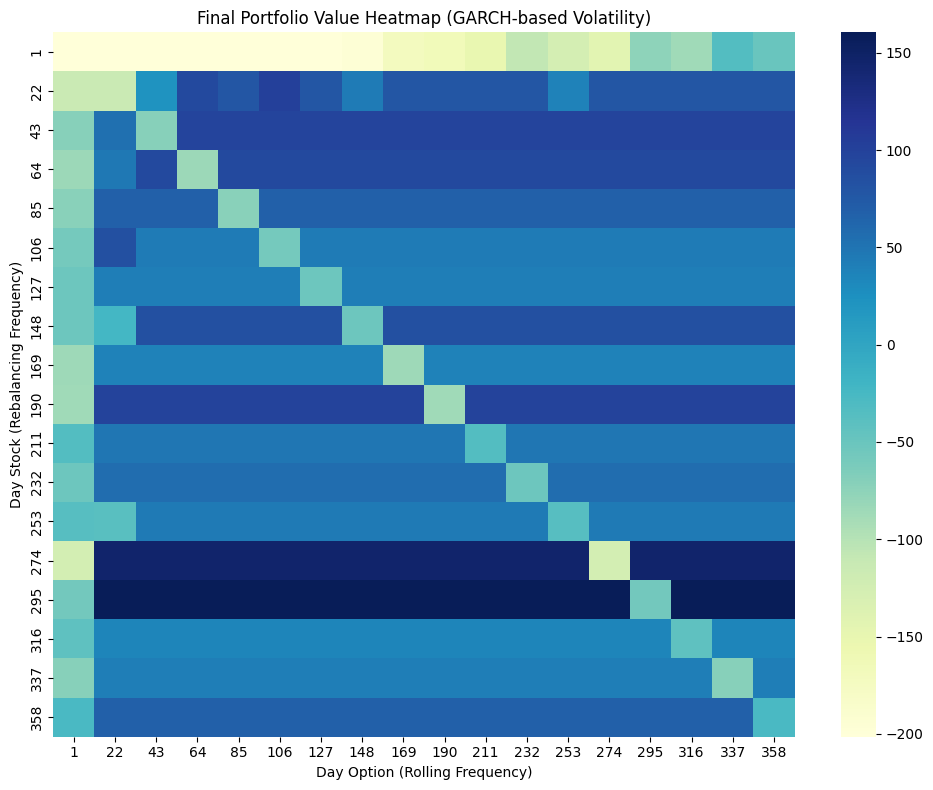

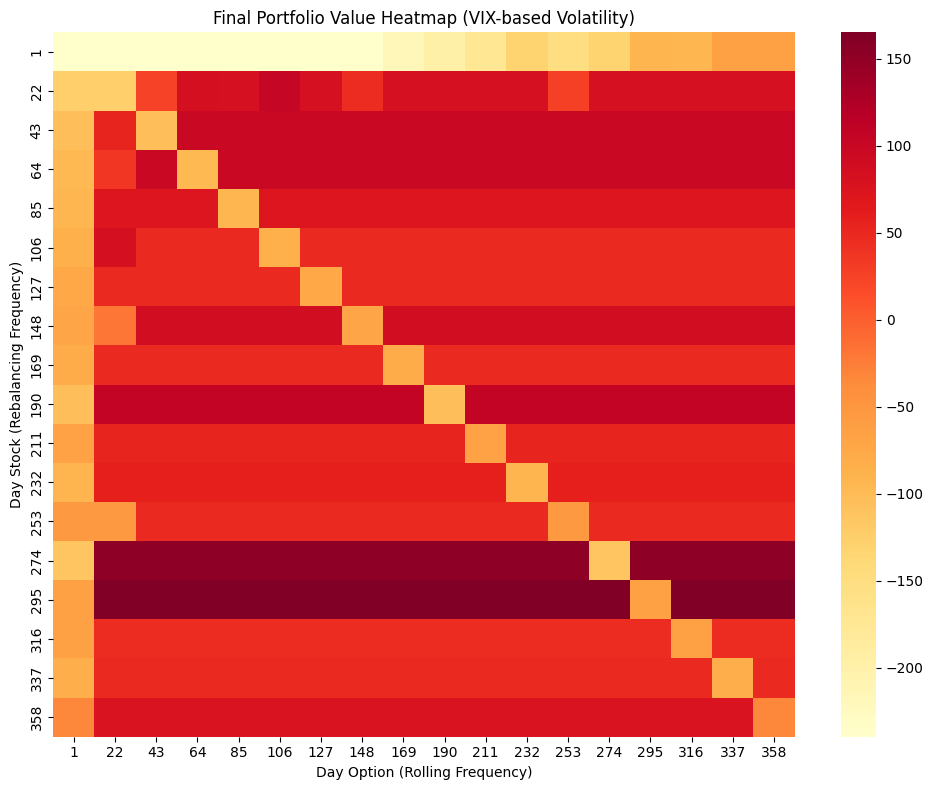

In [24]:
results_garch = pd.read_csv("parameter_sweep_results_garch.csv")
results_vix = pd.read_csv("parameter_sweep_results_vix.csv")

heatmap_data_garch = results_garch.pivot("day_stock", "day_option", "final_portfolio_value")
heatmap_data_vix = results_vix.pivot("day_stock", "day_option", "final_portfolio_value")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_garch, annot=False, fmt=".2f", cmap="YlGnBu", robust=True)
plt.title("Final Portfolio Value Heatmap (GARCH-based Volatility)")
plt.xlabel("Day Option (Rolling Frequency)")
plt.ylabel("Day Stock (Rebalancing Frequency)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_vix, annot=False, fmt=".2f", cmap="YlOrRd", robust=True)
plt.title("Final Portfolio Value Heatmap (VIX-based Volatility)")
plt.xlabel("Day Option (Rolling Frequency)")
plt.ylabel("Day Stock (Rebalancing Frequency)")
plt.tight_layout()
plt.show()